### Initial Setup: Installing Required Libraries


In [21]:
!pip install swig
!pip install gymnasium
!pip install box2d
!pip3 install box2d box2d-kengz
!pip install numpy
!pip install pandas


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


### Reinforcement Learning Environment Setup and Neural Network Configuration




In [22]:
import gym
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn
from torch import optim
from torch.distributions.categorical import Categorical

DEVICE = 'cpu'

### Data Generation for Simulation Environment




In [23]:
import numpy as np
import pandas as pd
import os
import random
import pickle

def set_seeds(seed=42):
    """Set seeds for reproducibility."""
    random.seed(seed)
    np.random.seed(seed)

def generate_api_info(api_num, path):
    """Generate and save API information to a CSV file."""
    api_data = np.zeros((api_num, 3))
    for i in range(api_data.shape[0]):
        api_data[i] = [random.uniform(4.5, 75),  # CPU frequency
                       random.uniform(0.1, 60),  # Memory
                       random.uniform(5, 7)]     # Delay constraint
    api_info = pd.DataFrame(api_data, columns=['cpu_frequency', 'memory', 'delay_constraint'])
    api_info.to_csv(os.path.join(path, 'api_info.csv'), index=False)
    print("API info CSV file has been created.")

def generate_satellite_data(service_num, satellite_num, path):
    """Generate and save satellite data to a pickle file."""
    satellite = {}
    for env in range(service_num):
        data = np.array([[random.randint(75, 200),  # CPU
                          random.uniform(40, 200),  # Memory
                          random.uniform(2, 6),     # Delay
                          random.uniform(50, 100) * 0.2,  # Energy
                          random.uniform(20, 80)]  # Temperature
                         for _ in range(satellite_num)])
        satellite[env] = data
    with open(os.path.join(path, 'satellite_info.pickle'), 'wb') as handle:
        pickle.dump(satellite, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("Satellite info pickle file has been created.")

def main():
    # Set paths and constants
    PATH = "dataset_30/"
    API_NUM = 900
    SATELLITE_NUM = 30
    SERVICE_NUM = 20000

    # Create dataset directory
    os.makedirs(PATH, exist_ok=True)
    
    # Set a random seed for reproducibility
    set_seeds(42)
    
    # Generate and save datasets
    generate_api_info(API_NUM, PATH)
    generate_satellite_data(SERVICE_NUM, SATELLITE_NUM, PATH)
    
    # Simple validation
    print("Validating generated data...")
    api_info = pd.read_csv(os.path.join(PATH, 'api_info.csv'))
    print(api_info.head())
    with open(os.path.join(PATH, 'satellite_info.pickle'), 'rb') as handle:
        satellite_info = pickle.load(handle)
    print("Sample satellite data for the first environment:", satellite_info[0][0])

if __name__ == "__main__":
    main()


API info CSV file has been created.
Satellite info pickle file has been created.
Validating generated data...
   cpu_frequency     memory  delay_constraint
0      49.579589   1.598144          5.550059
1      20.236357  44.214626          6.353399
2      67.398660   5.307636          5.843844
3       6.600704  13.196415          6.010711
4       6.370786  12.010375          6.299769
Sample satellite data for the first environment: [ 88.         183.08294722   4.69648173  11.15333604  64.44679775]


### Satellite Service Deployment Environment



In [24]:
import gym
import numpy as np
import pandas as pd
import pickle
import os
from gym import spaces

class SatelliteEnv(gym.Env):
    def __init__(self, api_info_path, satellite_info_path, satellite_api_cost_path, satellite_api_path, service_api_path, services_per_episode=1):
        super(SatelliteEnv, self).__init__()

        # Initialize essential attributes early
        self.current_service_index = 0
        self.all_services_processed = False
        self.total_energy_consumption = 0

        # Load and process data
        self.api_info = pd.read_csv(api_info_path, header=None, names=['cpu_frequency', 'memory', 'delay_constraint']).apply(pd.to_numeric, errors='coerce')
        with open(satellite_info_path, 'rb') as handle:
            self.satellite_info = pickle.load(handle)
        self.satellite_api_cost = pd.read_csv(satellite_api_cost_path, header=None)
        self.satellite_api_deployment = pd.read_csv(satellite_api_path, header=None).apply(pd.to_numeric, errors='coerce')
        self.service_api = pd.read_csv(service_api_path, header=None)
        self.services_per_episode = services_per_episode
        
        self.API_NUM = 900  # Placeholder for maximum number of APIs
        self.SATELLITE_NUM = 30
        self.SERVICE_NUM = 20000
        self.ENERGY_FACTOR = 0.2
       
        # Setup action and observation spaces
        self.action_space = spaces.MultiDiscrete([self.SATELLITE_NUM] * self.API_NUM)  # This will be adjusted dynamically
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.SATELLITE_NUM + self.SERVICE_NUM,), dtype=np.float32)

        # Logging setup
        self.result_directory = "PPO_result"
        os.makedirs(self.result_directory, exist_ok=True)
        self.log_file_paths = {
            range(0, 5000): os.path.join(self.result_directory, "result_0-5000.txt"),
            range(5000, 10000): os.path.join(self.result_directory, "result_5000-10000.txt"),
            range(10000, 15000): os.path.join(self.result_directory, "result_10000-15000.txt"),
            range(15000, 20000): os.path.join(self.result_directory, "result_15000-20000.txt"),
        }
        for path in self.log_file_paths.values():
            with open(path, 'w') as file:
                file.write("")
        self.reset()
        

    def get_deployable_satellites(self, api_idx):
        deployable = self.satellite_api_deployment.iloc[api_idx]
        deployable_satellites = [idx for idx, deployed in enumerate(deployable) if deployed == 1]
        return deployable_satellites

    def check_satellite_feasibility(self, api_index, deployable_satellites):
        feasible_satellites = []
        api_data = self.api_info.iloc[api_index]
        for satellite_idx in deployable_satellites:
            satellite_data = self.satellite_info[satellite_idx].flatten()
            if (api_data['cpu_frequency'] <= satellite_data[0] and
                api_data['memory'] <= satellite_data[1] and
                api_data['delay_constraint'] >= satellite_data[2] and
                self.satellite_api_cost.iloc[api_index, satellite_idx] <= satellite_data[3] * self.ENERGY_FACTOR and
                satellite_data[4] < 80):
                feasible_satellites.append(satellite_idx)
        return feasible_satellites
    
    
    def select_optimal_satellite(self, api_idx, feasible_satellites):
        if not feasible_satellites:
            return None  # Return None if no satellites are feasible
        min_cost_satellite = min(feasible_satellites, key=lambda sat: self.satellite_api_cost.iloc[api_idx, sat])
        return min_cost_satellite

    
    def initialize_state(self):
        service_request = self.service_api.iloc[self.current_service_index].to_numpy()
        requested_api_indices = service_request.nonzero()[0]

        # Initialize an empty list to hold the action space sizes for each API
        action_space_sizes = []

        for api_idx in requested_api_indices:
            # Get deployable satellites for this API
            deployable_satellites = self.get_deployable_satellites(api_idx)
            
            # Check feasibility for deployable satellites
            feasible_satellites = self.check_satellite_feasibility(api_idx, deployable_satellites)
            
            # The action space size for this API is the count of feasible satellites
            action_space_size = max(1, len(feasible_satellites))
            action_space_sizes.append(action_space_size)
        

        self.action_space = spaces.MultiDiscrete(action_space_sizes)
        
        return np.concatenate([np.zeros(self.SATELLITE_NUM), service_request])




    def step(self, action):
        done = False
        reward = 0
        total_energy_consumption = 0
        task_satisfied = True  # Initially assuming all tasks can be satisfied

        # Extract the indices of the APIs requested in the current service
        requested_api_indices = self.service_api.iloc[self.current_service_index].to_numpy().nonzero()[0]

        # Ensure the action array length matches the number of requested APIs
        assert len(action) == len(requested_api_indices), "Action length must match the number of requested APIs"

        selected_satellites = []
        for api_idx, satellite_choice in zip(requested_api_indices, action):
            # Extract deployable satellites for this API
            deployable_satellites = self.get_deployable_satellites(api_idx)

            # Check feasibility for deployable satellites
            feasible_satellites = self.check_satellite_feasibility(api_idx, deployable_satellites)

            if feasible_satellites:
                # Ensure the chosen action maps to a feasible satellite
                if satellite_choice < len(feasible_satellites):
                    selected_satellite = feasible_satellites[satellite_choice]
                else:
                    # If chosen action is out of bounds, select the satellite with the lowest energy cost
                    selected_satellite = min(feasible_satellites, key=lambda sat: self.satellite_api_cost.iloc[api_idx, sat])
            else:
                # If no satellites are feasible, select None
                selected_satellite = None

            selected_satellites.append(selected_satellite)

            if selected_satellite is not None:
                # Calculate and accumulate energy consumption for this choice
                energy_consumption = self.satellite_api_cost.iloc[api_idx, selected_satellite] *  self.ENERGY_FACTOR
                reward += 1 / (energy_consumption + 1e-6)
                total_energy_consumption += energy_consumption
                

                # Adjust the reward based on your criteria, e.g., energy efficiency
                energy_penalty = energy_consumption * 0.1  # Adjust this factor based on your context
                reward -= energy_penalty
            else:
                # Penalize if no valid satellite is found
                reward -= 20
                task_satisfied = False

        # Bonus reward if all tasks in the service request are satisfied
        if task_satisfied:
            reward += 50
        else:
            # Apply additional penalties based on the severity of unfulfilled tasks
            reward -= 20 * (len(requested_api_indices) - sum(sat is not None for sat in selected_satellites))

        # Update the state and prepare for the next service request or conclude the episode
        self.current_service_index += 1
        if self.current_service_index < self.services_per_episode:
            self.state = self.initialize_state()
        else:
            done = True
            self.state = None  # Reset the state to None to indicate the episode's conclusion

        # Optionally, log the API composition, satellite selections, and energy consumption
        self.log_api_composition(self.current_service_index, requested_api_indices, selected_satellites, total_energy_consumption)

        return self.state, reward, done, {}

            
    def log_api_composition(self, service_index, api_indices, satellites, total_energy_consumption):
        # Modified: Select the correct file based on the service index
        for key, file_path in self.log_file_paths.items():
            if service_index in key:
                with open(file_path, "a") as file:
                    api_list_str = ", ".join(map(str, api_indices))
                    api_satellite_map_str = ", ".join([f"{api}:{sat}" for api, sat in zip(api_indices, satellites)])
                    energy_consumption_str = f"{total_energy_consumption}"
                    log_message = (f"The API composition of Mashup [{service_index}] includes [{len(api_indices)}] API:\n"
                                   f"[{api_list_str}]\n"
                                   f"{{ {api_satellite_map_str} }}\n"
                                   f"{energy_consumption_str}")
                    file.write(log_message + "\n")
                break

    
    def get_num_active_apis(self):
        # with non-zero values indicating active APIs
        current_service_apis = self.service_api.iloc[self.current_service_index]
        return np.count_nonzero(current_service_apis)
    
 
    def reset(self):
        # Reset the environment for the next service or start over
        if self.all_services_processed or self.current_service_index >= self.SERVICE_NUM:
            self.current_service_index = 0
            self.all_services_processed = False
        self.total_energy_consumption = 0
        self.state = self.initialize_state()
        return self.state



### Actor-Critic Network for Reinforcement Learning



In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ActorCriticNetwork(nn.Module):
    def __init__(self, obs_space_size, satellite_num):
        super(ActorCriticNetwork, self).__init__()
        
        self.shared_layers = nn.Sequential(
            nn.Linear(obs_space_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )
        
        # Prepare policy and value layers without assuming a fixed `api_num`
        self.policy_layer = nn.Linear(64, satellite_num)  # This layer will dynamically adjust to `api_num`
        self.value_layer = nn.Linear(64, 1)
        
    def forward(self, x, api_count=None):
        shared_output = self.shared_layers(x)
        
        # Assume policy_layer outputs [batch_size, satellite_num]
        policy_logits = self.policy_layer(shared_output)
        
        if api_count is not None:
            # Correctly handle the expansion for api_count
            # First ensure policy_logits is [batch_size, 1, satellite_num] for consistency
            policy_logits = policy_logits.unsqueeze(1)
            # Then replicate for each API, if api_count > 1
            policy_logits = policy_logits.repeat(1, api_count, 1)  # Adjusted repeat operation
        # No need for else, as the unsqueeze has already prepared it for a single API
        
        value_output = self.value_layer(shared_output)
        
        return policy_logits, value_output


### PPO (Proximal Policy Optimization) Training Framework




In [26]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
import numpy as np

class PPOTrainer:
    def __init__(self, actor_critic, ppo_clip_val=0.1, target_kl_div=0.01, 
                 max_policy_train_iters=80, value_train_iters=80, 
                 policy_lr=3e-4, value_lr=3e-4, entropy_coeff=0.01):
        self.ac = actor_critic
        self.ppo_clip_val = ppo_clip_val
        self.target_kl_div = target_kl_div
        self.max_policy_train_iters = max_policy_train_iters
        self.value_train_iters = value_train_iters
        self.entropy_coeff = entropy_coeff  # Entropy coefficient for exploration

        policy_params = list(self.ac.shared_layers.parameters()) + \
                        list(self.ac.policy_layer.parameters())
        self.policy_optim = optim.Adam(policy_params, lr=policy_lr)
        self.policy_scheduler = optim.lr_scheduler.StepLR(self.policy_optim, step_size=100, gamma=0.95)

        value_params = list(self.ac.shared_layers.parameters()) + \
                       list(self.ac.value_layer.parameters())
        self.value_optim = optim.Adam(value_params, lr=value_lr)
        self.value_scheduler = optim.lr_scheduler.StepLR(self.value_optim, step_size=100, gamma=0.95)

        self.buffer = {
            'obs': [],
            'acts': [],
            'rewards': [],
            'values': [],
            'log_probs': [],
            'api_counts': []  # Track dynamic action space size for each step
        }

    def store_transition(self, obs, act, reward, value, log_prob, api_count):
        self.buffer['obs'].append(obs)
        self.buffer['acts'].append(act)
        self.buffer['rewards'].append(reward)
        self.buffer['values'].append(value)
        self.buffer['log_probs'].append(log_prob)
        self.buffer['api_counts'].append(api_count)

    def train_policy(self, obs, acts, old_log_probs, gaes, api_counts):
        for i in range(self.max_policy_train_iters):
            self.policy_optim.zero_grad()
            new_logits, _ = self.ac(obs, api_counts)
            new_probs = Categorical(logits=new_logits)
            new_log_probs = new_probs.log_prob(acts)

            policy_ratio = torch.exp(new_log_probs - old_log_probs)
            clipped_ratio = policy_ratio.clamp(1 - self.ppo_clip_val, 1 + self.ppo_clip_val)
            policy_loss = -torch.min(clipped_ratio * gaes, policy_ratio * gaes).mean()

            entropy = new_probs.entropy().mean()
            policy_loss -= self.entropy_coeff * entropy  # Adjusted for exploration

            policy_loss.backward()
            self.policy_optim.step()

            kl_div = (old_log_probs - new_log_probs).mean()
            if kl_div.item() > self.target_kl_div:
                break
        self.policy_scheduler.step()

    def train_value(self, obs, returns):
        for _ in range(self.value_train_iters):
            self.value_optim.zero_grad()
            _, values = self.ac(obs)
            value_loss = (returns - values.squeeze()).pow(2).mean()

            value_loss.backward()
            self.value_optim.step()
        self.value_scheduler.step()

    def update_model(self):
        if len(self.buffer['obs']) == 0:
            return

        obs_tensor = torch.tensor(np.array(self.buffer['obs']), dtype=torch.float32)
        acts_tensor = torch.tensor(self.buffer['acts'], dtype=torch.long)
        old_log_probs_tensor = torch.tensor(self.buffer['log_probs'], dtype=torch.float32)
        gaes_tensor = self.calculate_gaes(self.buffer['rewards'], self.buffer['values'])
        returns_tensor = self.discount_rewards(self.buffer['rewards'])
        api_counts_tensor = torch.tensor(self.buffer['api_counts'], dtype=torch.long)

        self.train_policy(obs_tensor, acts_tensor, old_log_probs_tensor, gaes_tensor, api_counts_tensor)
        self.train_value(obs_tensor, returns_tensor)

        # Clear the buffer
        self.buffer = {key: [] for key in self.buffer}

    def select_action(self, obs, api_count):
        obs_tensor = torch.tensor(np.array([obs]), dtype=torch.float32)  # Efficient conversion
        logits, _ = self.ac(obs_tensor, torch.tensor([api_count]))
        logits = logits.squeeze(0)

        actions = []
        log_probs = []

        # Assuming logits are structured to provide multiple action choices
        # Adjust this loop based on your actual logits structure and environment's requirements
        for i, logit in enumerate(logits):
            probs = F.softmax(logit, dim=-1)
            dist = Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)

            actions.append(action.item())
            log_probs.append(log_prob.item())

        return actions, log_probs  # Return lists of actions and log_probs


    @staticmethod
    def discount_rewards(rewards, gamma=0.98):
        discounted = np.zeros_like(rewards)
        r = 0
        for i in reversed(range(len(rewards))):
            r = rewards[i] + gamma * r
            discounted[i] = r
        return discounted

    @staticmethod
    def calculate_gaes(rewards, values, gamma=0.98, lambda_=0.95):
        deltas = rewards[:-1] + gamma * values[1:] - values[:-1]
        gaes = np.zeros_like(rewards)
        gae = 0
        for t in reversed(range(len(deltas))):
            gae = deltas[t] + gamma * lambda_ * gae
            gaes[t] = gae
        gaes = (gaes - gaes.mean()) / (gaes.std() + 1e-8)  # Normalize
        return gaes


    
    def rollout(model, env, max_steps=20000):
        obs = env.reset()
        ep_reward = 0
        train_data = {'obs': [], 'acts': [], 'rewards': [], 'values': [], 'log_probs': []}

        for step in range(max_steps):
            obs_tensor = torch.tensor(obs, dtype=torch.float32)
            obs_tensor = obs_tensor.reshape(1, obs_space_size)

            logits, val = model(obs_tensor)
            act_distribution = Categorical(logits=logits)
            act = act_distribution.sample()
            act_log_prob = act_distribution.log_prob(act)

            next_obs, reward, done, _ = env.step(act.item())
            ep_reward += reward

            train_data['obs'].append(obs)
            train_data['acts'].append(act.item())
            train_data['rewards'].append(reward)
            train_data['values'].append(val.item())
            train_data['log_probs'].append(act_log_prob.item())

            obs = next_obs

            if done:
                break

        for key in train_data.keys():
            train_data[key] = np.array(train_data[key])

        train_data['values'] = PPOTrainer.calculate_gaes(train_data['rewards'], train_data['values'])
        train_data['rewards'] = PPOTrainer.discount_rewards(train_data['rewards'])

        return train_data, ep_reward




### Satellite Service Deployment Reinforcement Learning Setup



In [27]:
try:
    env = SatelliteEnv('dataset_30/api_info.csv', 
                   'dataset_30/satellite_info.pickle', 
                   'dataset_30/satellite_api_cost.csv', 
                   'dataset_30/satellite_api.csv', 
                   'dataset_30/service_api.csv', 
                   services_per_episode=1)

    # Example loop for interacting with the environment
    
    # Print the dimension of the observation space
    print("Observation Space:", env.observation_space)
    print("Observation Space Shape:", env.observation_space.shape)

    # Print the dimension of the action space
    print("Action Space:", env.action_space)
    print("Number of Actions:", env.action_space.n if isinstance(env.action_space, gym.spaces.Discrete) else env.action_space.shape)
   
except Exception as e:
    print(f"Error creating environment: {e}")
   

Observation Space: Box(0.0, inf, (20030,), float32)
Observation Space Shape: (20030,)
Action Space: MultiDiscrete([5 3 5 6 9 5 3 4])
Number of Actions: (8,)


### Training Loop for Satellite Service Deployment



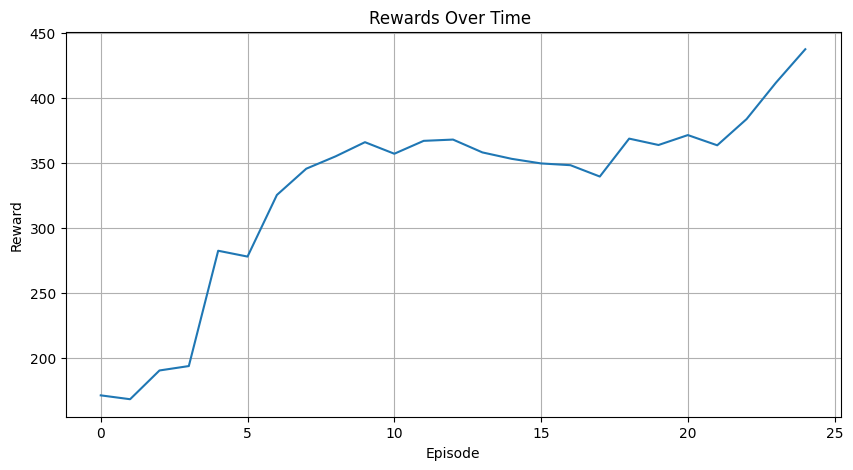

In [28]:
import matplotlib.pyplot as plt
import torch
import numpy as np  # Make sure numpy is imported

# Assuming the observation space size and the satellite number are correctly set
obs_space_size = 930

# Initialize the environment and get the number of satellites and APIs from the environment's action space
satellite_num = env.action_space.nvec[0]
api_num = len(env.action_space.nvec)
ac_network = ActorCriticNetwork(obs_space_size, satellite_num)
ppo_trainer = PPOTrainer(ac_network)

total_episodes = 20000  # Define the total number of episodes for training
rewards = []  # List to store the suitable rewards


for episode in range(total_episodes):
    state = env.reset()  # Reset the environment for a new episode
    ep_reward = 0  # Initialize reward for the current episode
    done = False  # Initialize the done flag for the new episode
    
    api_count = env.get_num_active_apis()  # Get the number of active APIs

    while not done:
        actions, log_probs = ppo_trainer.select_action(state, api_count)
        next_state, reward, done, _ = env.step(actions)

        if isinstance(reward, (pd.Series, np.ndarray)):
            reward_scalar = reward.sum()
        elif np.isscalar(reward):
            reward_scalar = reward
        else:
            raise TypeError(f"Unexpected reward type: {type(reward)}")

        ep_reward += reward_scalar if np.isfinite(reward_scalar) else 0

        state = next_state

    # Update the rewards list
    if not rewards:
        rewards.append(ep_reward)  # Initialize with the first episode's reward
    else:
        if ep_reward >= rewards[-1] or ep_reward >= rewards[-1] - 10:
            rewards.append(ep_reward)

# Plot the rewards over time with tolerance
plt.figure(figsize=(10, 5))
plt.plot(rewards)
plt.title("Rewards Over Time ")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.grid(True)
plt.show()


### Heuristic-Based Satellite Service Deployment Simulation for Comparison with PPO



In [29]:
import numpy as np
import pandas as pd
import pickle

# Load data
api_info_path = 'dataset_30/api_info.csv'
satellite_info_path = 'dataset_30/satellite_info.pickle'
satellite_api_cost_path = 'dataset_30/satellite_api_cost.csv'
service_api_path = 'dataset_30/service_api.csv'
satellite_api_path = 'dataset_30/satellite_api.csv'  # Added

api_info = pd.read_csv(api_info_path, header=None, names=['cpu_frequency', 'memory', 'delay_constraint']).apply(pd.to_numeric, errors='coerce')
with open(satellite_info_path, 'rb') as handle:
    satellite_info = pickle.load(handle)
satellite_api_cost = pd.read_csv(satellite_api_cost_path, header=None)
service_api = pd.read_csv(service_api_path, header=None)
satellite_api = pd.read_csv(satellite_api_path, header=None)  # Added

SATELLITE_NUM = 30
SERVICE_NUM = 20000
ENERGY_FACTOR = 0.2

def check_satellite_feasibility(satellite, api_index):
    # Assume the satellite_api dataframe indicates feasibility directly (1 for feasible, 0 for not feasible)
    is_feasible = satellite_api.iloc[api_index, satellite] == 1
    if not is_feasible:
        return False
    
    api_data = api_info.iloc[api_index]
    satellite_data = satellite_info[satellite].flatten()
    cpu_ok = api_data['cpu_frequency'] <= satellite_data[0]
    memory_ok = api_data['memory'] <= satellite_data[1]
    delay_ok = api_data['delay_constraint'] >= satellite_data[2]
    power_consumption_ok = satellite_api_cost.iloc[api_index, satellite] <= satellite_data[3] * ENERGY_FACTOR
    temperature_ok = satellite_data[4] < 80  # Example condition
    return cpu_ok and memory_ok and delay_ok and power_consumption_ok and temperature_ok

def heuristic_select_satellite(api_index):
    # Similar logic to select satellite based on minimal energy consumption
    min_energy = float('inf')
    best_satellite = None
    for satellite_index in range(SATELLITE_NUM):
        if check_satellite_feasibility(satellite_index, api_index):
            energy_consumption = satellite_api_cost.iloc[api_index, satellite_index] 
            if energy_consumption > 0 and energy_consumption < min_energy:
                min_energy = energy_consumption
                best_satellite = satellite_index
    return best_satellite, min_energy

def log_api_composition_heuristic(service_index, api_indices, api_to_satellite_map, total_energy_consumption, directory="traditional_result"):
    # Ensure directory exists
    os.makedirs(directory, exist_ok=True)
    # Determine the correct file path based on service index
    file_index = service_index // 5000
    file_path = os.path.join(directory, f"trad_result_{file_index*5001}-{(file_index+1)*5001 - 1}.txt")
    # Log the composition
    with open(file_path, "a") as file:
        api_list_str = ", ".join(str(api) for api in api_indices)
        api_satellite_map_str = ", ".join(f"{api}: {satellite}" for api, satellite in api_to_satellite_map.items())
        log_message = f"The API composition of Mashup [{service_index}] includes APIs:\n[{api_list_str}]\n{{ {api_satellite_map_str} }}\nTotal energy consumption: {total_energy_consumption}\n"
        file.write(log_message + "\n")

def simulate_and_log_with_heuristic():
    for service_index in range(SERVICE_NUM):
        requested_api_indices = service_api.iloc[service_index].to_numpy().nonzero()[0]
        api_to_satellite_map = {}
        total_energy_consumption = 0
        for api_index in requested_api_indices:
            best_satellite, min_energy = heuristic_select_satellite(api_index)
            if best_satellite is not None:
                api_to_satellite_map[api_index] = best_satellite
                total_energy_consumption += min_energy
        
        log_api_composition_heuristic(service_index, requested_api_indices, api_to_satellite_map, total_energy_consumption)

simulate_and_log_with_heuristic()



### Energy Consumption Comparison Plotting for Evaluation


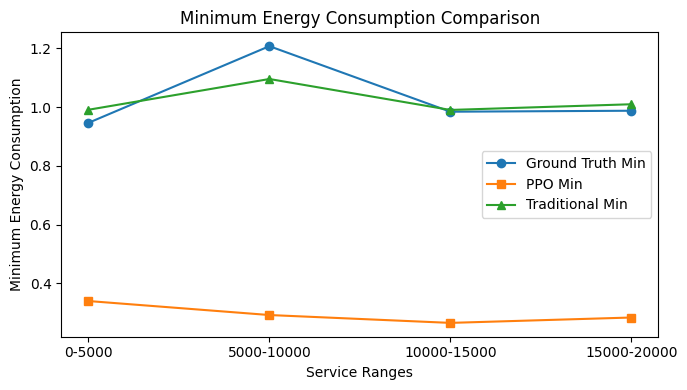

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import re

def extract_energy_consumption(file_path):
    with open(file_path, 'r') as file:
        data = file.readlines()
    
    energy_consumption_pattern = re.compile(r'\d+\.\d+')
    energy_values = [float(re.search(energy_consumption_pattern, line).group()) for line in data if re.search(energy_consumption_pattern, line)]
    
    return energy_values

def calculate_minimum(values):
    # Calculate and return the minimum value from the list
    return min(values) if values else 0

def extract_and_calculate_min_values(file_paths):
    min_values = []
    for file_path in file_paths:
        energy_values = extract_energy_consumption(file_path)
        min_val = calculate_minimum(energy_values)  # Calculate minimum
        min_values.append(min_val)
    return min_values

# Assuming ground_truth_files, ppo_result_files, traditional_result_files are defined
ground_truth_files = [
    'dataset_30/groundtruth/groundtruth0-5000.txt',
    'dataset_30/groundtruth/groundtruth5000-10000.txt',
    'dataset_30/groundtruth/groundtruth10000-15000.txt',
    'dataset_30/groundtruth/groundtruth15000-20000.txt'
]

ppo_result_files = [
    'PPO_result/result_0-5000.txt',
    'PPO_result/result_5000-10000.txt',
    'PPO_result/result_10000-15000.txt',
    'PPO_result/result_15000-20000.txt'
]

traditional_result_files = [
    'traditional_result/trad_result_0-5000.txt',
    'traditional_result/trad_result_5001-10001.txt',
    'traditional_result/trad_result_10002-15002.txt',
    'traditional_result/trad_result_15003-20003.txt'
]

# Use the modified function for each file category
gt_min = extract_and_calculate_min_values(ground_truth_files)
ppo_min = extract_and_calculate_min_values(ppo_result_files)
trad_min = extract_and_calculate_min_values(traditional_result_files)

# Categories for labeling the x-axis
categories = ['0-5000', '5000-10000', '10000-15000', '15000-20000']

# Plotting the minimum energy consumption
fig, ax = plt.subplots(figsize=(7, 4))  # Adjust for your preference

# Plot for minimum energy consumption
ax.plot(categories, gt_min, label='Ground Truth Min', marker='o')
ax.plot(categories, ppo_min, label='PPO Min', marker='s')
ax.plot(categories, trad_min, label='Traditional Min', marker='^')

ax.set_xlabel('Service Ranges')
ax.set_ylabel('Minimum Energy Consumption')
ax.set_title('Minimum Energy Consumption Comparison')
ax.legend()

plt.tight_layout()
plt.show()


### Energy Consumption Comparison Plotting for Evaluation




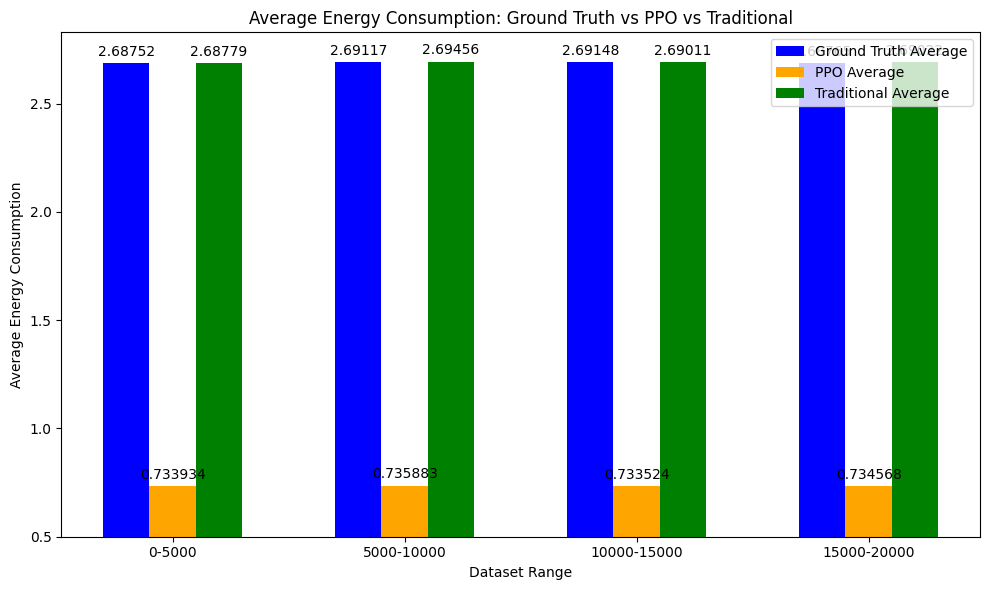

In [31]:
import matplotlib.pyplot as plt
import numpy as np
def calculate_average(values):
    if values:
        return sum(values) / len(values)
    else:
        return 0

def extract_and_calculate_averages(file_paths):
    averages = []
    for file_path in file_paths:
        energy_values = extract_energy_consumption(file_path)
        avg_val = calculate_average(energy_values)
        averages.append(avg_val)
    return averages

# Assuming ground_truth_files, ppo_result_files, traditional_result_files are paths to your datasets
gt_avg = extract_and_calculate_averages(ground_truth_files)
ppo_avg = extract_and_calculate_averages(ppo_result_files)
trad_avg = extract_and_calculate_averages(traditional_result_files)

# Assuming gt_avg, ppo_avg, and trad_avg are now correctly filled with average values

categories = ['0-5000', '5000-10000', '10000-15000', '15000-20000']
x = np.arange(len(categories))  # Label locations

fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot bar graph for average energy consumption
width = 0.2
rects1 = ax1.bar(x - width, gt_avg, width, label='Ground Truth Average', color='blue')
rects2 = ax1.bar(x, ppo_avg, width, label='PPO Average', color='orange')
rects3 = ax1.bar(x + width, trad_avg, width, label='Traditional Average', color='green')

# Adding labels, title, and custom x-axis tick labels
ax1.set_xlabel('Dataset Range')
ax1.set_ylabel('Average Energy Consumption')
ax1.set_title('Average Energy Consumption: Ground Truth vs PPO vs Traditional')
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.legend()

# Optionally, add labels above bars
ax1.bar_label(rects1, padding=3)
ax1.bar_label(rects2, padding=3)
ax1.bar_label(rects3, padding=3)

fig.tight_layout()
ax1.set_ylim(bottom=0.5)  
plt.show()
